In [ ]:
import pandas as pd
from src.paths import TRANSFORMED_DATA_DIR

In [2]:
data = pd.read_csv(TRANSFORMED_DATA_DIR / 'ts_tabular_2022_10_to_2024_10.csv')
# Wrangling index for deriving exog features
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data.head()

,ba_AECI,ba_AVA,ba_AZPS,ba_BANC,ba_BPAT,ba_CHPD,ba_CISO,ba_CPLE,ba_CPLW,ba_DOPD,...,ba_SWPP,ba_TAL,ba_TEC,ba_TEPC,ba_TIDC,ba_TPWR,ba_TVA,ba_WACM,ba_WALC,ba_WAUW
datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-01,51628.0,27070.0,96193.0,46398.0,123905.0,3745.0,592567.0,123640.0,11797.0,4617.0,...,649266.0,6601.0,49325.0,34960.0,8222.0,10804.0,348678.0,80299.0,24633.0,1820.0
2022-10-02,53127.0,28039.0,97208.0,42814.0,125317.0,3655.0,560074.0,124418.0,11759.0,4583.0,...,647709.0,6682.0,51702.0,37336.0,7194.0,10773.0,345900.0,79702.0,26100.0,1749.0
2022-10-03,54708.0,30110.0,96570.0,47041.0,133353.0,3790.0,623658.0,132803.0,12155.0,4732.0,...,689771.0,6886.0,54270.0,35662.0,8346.0,11228.0,373596.0,80536.0,25310.0,1915.0
2022-10-04,53345.0,30764.0,88963.0,48332.0,134664.0,3831.0,654561.0,134430.0,12294.0,4829.0,...,687579.0,6781.0,53101.0,31415.0,8765.0,10927.0,378071.0,80522.0,23938.0,1838.0
2022-10-05,53356.0,30421.0,91984.0,50362.0,135464.0,3815.0,664304.0,136348.0,12482.0,4854.0,...,687179.0,7009.0,54212.0,30993.0,8457.0,10962.0,376763.0,81362.0,23839.0,1828.0


In [4]:
# Make exog features
import holidays

# Explicitly set freqency of index
data = data.asfreq("1D")

us_holidays = holidays.US(years=[2022, 2023, 2024])
data["exog_is_holiday"] = data.index.map(lambda day: day in us_holidays).astype(int)

data["exog_month"] = data.index.month
data["exog_day_of_week"] = data.index.dayofweek
data["exog_is_weekend"] = data["exog_day_of_week"].isin([5, 6]).astype(int)

# Winter = 12, 1, 2; Spring = 3, 4, 5; ...
data["exog_season"] = ((data["exog_month"] % 12) // 3) + 1

In [5]:
data.filter(like="exog_").head()

,exog_is_holiday,exog_month,exog_day_of_week,exog_is_weekend,exog_season
datetime,,,,,
2022-10-01,0,10,5,1,4
2022-10-02,0,10,6,1,4
2022-10-03,0,10,0,0,4
2022-10-04,0,10,1,0,4
2022-10-05,0,10,2,0,4


In [11]:
# Train/test split of ~50:50. We'll need 365 days worth of data to capture the yearly seasonality
end_train = "2023-10-31 23:59:00"
data_train = data.loc[:end_train, :].copy()
data_test = data.loc[end_train:, :].copy()

print(f"{data_train.shape=}")
print(f"{data_test.shape=}")

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

data_train.shape=(396, 58)
data_test.shape=(366, 58)
Train dates : 2022-10-01 00:00:00 --- 2023-10-31 00:00:00   (n=396)
Test dates  : 2023-11-01 00:00:00 --- 2024-10-31 00:00:00   (n=366)


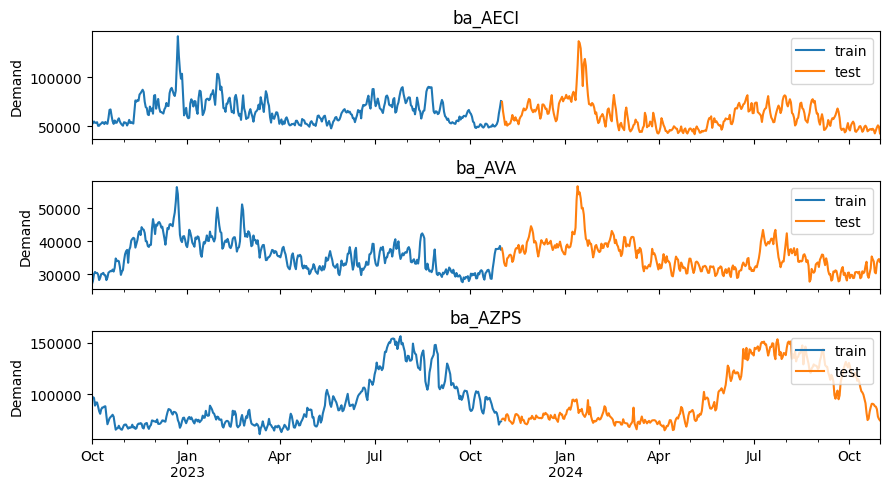

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

for i, col in enumerate(data.columns[:3]):
    data_train[col].plot(ax=axes[i], label="train")
    data_test[col].plot(ax=axes[i], label="test")
    axes[i].set_title(col)
    axes[i].set_ylabel("Demand")
    axes[i].set_xlabel("")
    axes[i].legend(loc="upper right")

fig.tight_layout()
plt.show()